# NMR Processing Overview

---

1. Split files into different categories.
    1. How many individual fids?
    2. How many array experiments?
    3. How are temperature sets stored?
    4. How are materials stored?
2. Develop / confirm metadata for those categories.
    + Cross reference with documentation provided by Trent.
    + Compare processing demo results to Trent's data. 
    + Meet with Trent to confirm assignments.
3. Prioritize subsets.
3. **Design Bokeh application**
4. Process subsets.

In [1]:
%load_ext autoreload
%autoreload 2

#### Set Local Data Path

---

Since the total available data is around 2 gb it may be stored in different locations on different machines. Define a base path to the data to simplify this.

In [2]:
# data_folder = '/home/tylerbiggs/data/Sep-2016-23Na'
# processed_data = "/home/tylerbiggs/data/processed_nmr"
data_folder = '/home/tyler/data/Sep-2016-23Na'
processed_data = "/home/tyler/data/processed_nmr"

In [3]:
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import multiprocessing as mp
import glob
import re
import os
from tqdm import tqdm
%matplotlib inline

In [4]:
from trentnmr import *

# File Structure

---

From `tree -I *.fid` to find all non-fid directories.

```bash
└── Sep-2016-23Na
    ├── 23Na
    │   └── 27Al
    │       ├── 0808G1-0p15M-AlOH3-3M-NaOH-D2O
    │       ├── 0808G1-0p5M-AlOH3-3M-NaOH-D2O
    │       ├── 0808G1-1M-AlOH3-3M-NaOH-D2O
    │       ├── 0819G1-0p1M-AlOH3-3M-LiOH-D2O
    │       ├── 0819G1-0p5M-AlOH3-3M-KOH-D2O
    │       ├── 0819G1-0p5M-AlOH3-3M-LiOH-D2O
    │       ├── 0819G1-1M-AlOH3-3M-NaOH-D2O
    │       ├── background
    │       └── standard
    └── VT

```

Which seems like and error. Re-ordering to:

```bash
└── Sep-2016-23Na
    ├── 23Na
    ├── 27Al
    │   ├── 0808G1-0p15M-AlOH3-3M-NaOH-D2O
    │   ├── 0808G1-0p5M-AlOH3-3M-NaOH-D2O
    │   ├── 0808G1-1M-AlOH3-3M-NaOH-D2O
    │   ├── 0819G1-0p1M-AlOH3-3M-LiOH-D2O
    │   ├── 0819G1-0p5M-AlOH3-3M-KOH-D2O
    │   ├── 0819G1-0p5M-AlOH3-3M-LiOH-D2O
    │   ├── 0819G1-1M-AlOH3-3M-NaOH-D2O
    │   ├── background
    │   └── standard
    └── VT

```

## Glob Parent Folders

---

In [5]:
# Sodium folders.
VT   = os.path.join(data_folder, 'VT')
Na23 = os.path.join(data_folder, '23Na')

# Aluminum folders.
Al27 = os.path.join(data_folder, '27Al')
# Aluminum sub-paths.
sub_paths_strings = [
    "0808G1-0p15M-AlOH3-3M-NaOH-D2O",
    "0808G1-0p5M-AlOH3-3M-NaOH-D2O",
    "0808G1-1M-AlOH3-3M-NaOH-D2O",
    "0819G1-0p1M-AlOH3-3M-LiOH-D2O",
    "0819G1-0p5M-AlOH3-3M-KOH-D2O",
    "0819G1-0p5M-AlOH3-3M-LiOH-D2O",
    "0819G1-1M-AlOH3-3M-NaOH-D2O",
    "background",
    "standard"
]

Al_sub_paths = [os.path.join(Al27, p) for p in sub_paths_strings]

In [6]:
Al_sub_paths.append(Al27)
sodium_paths = [VT, Na23]

## Glob Helper Functions

---

In [7]:
array_glob = '/*arrays*.fid'
mis_arrays = '/*arryas*.fid'
fid_glob = '/*.fid'
special_files = ['reference', 'REF', 'calibration', 'pwX90', 'static',
                 'spin-up', 'without-liquid']

def nmr_glob(path):
    arrays = {fn for fn in glob.iglob(path + array_glob, recursive=False)}
    other_arrays = {fn for fn in glob.iglob(path + mis_arrays, recursive=False)}
    arrays = arrays | other_arrays
    
    fids = {fn for fn in glob.iglob(path + fid_glob, recursive=False)}
    
    other_fids = set()
    for f in fids:
        if any(sf in f for sf in special_files):
            other_fids.add(f)

    fids = fids - other_fids - arrays
            
    return [list(x) for x in [arrays, fids, other_fids]]


def trim_folder(folders):
    return [os.sep.join(os.path.normpath(path).split(os.sep)[5:]) for path in folders]


def process_group(path_list):
    array, fid, other = list(), list(), list()
    for path in path_list:
        a, f, o = nmr_glob(path)
        if a: array.append(a)
        if f: fid.append(f)        
        if o: other.append(o)
        
    return [list(itertools.chain.from_iterable(x)) for x in [array, fid, other]]

## Running the Globs

---

In [8]:
al_array, al_fid, al_other = process_group(Al_sub_paths)
na_array, na_fid, na_other = process_group(sodium_paths)

In [9]:
print(f'Normal Al fids: {len(al_fid)}')

Normal Al fids: 139


# Processing the .fid Files

---

### Convert to NMRPipe files

In [10]:
al_fid_pipes = list()
for x in tqdm(al_fid):
    al_fid_pipes.append(write_varian_as_pipe(x, processed_data))

100%|██████████| 139/139 [00:00<00:00, 179.74it/s]


### Process NMR Pipe Files

Takes a few minutes...

In [11]:
def mp_proc_pipe(in_file, processed_data):
    return process_pipe_file(in_file, processed_data)

def pool_nmr_proc(file_list, processes=mp.cpu_count() - 1):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(mp_proc_pipe, args=(v, processed_data)) for v in file_list]
    results = [p.get() for p in results]
    return results

In [12]:
proccessed_al_fids = pool_nmr_proc(al_fid_pipes)

Optimization terminated successfully.
         Current function value: 133989920008.275940
         Iterations: 112
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: 4221594112008.951660
         Iterations: 116
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 18014490624009.156250
         Iterations: 119
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 15752263680009.169922
         Iterations: 108
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 77471579897856016.000000
         Iterations: 105
         Function evaluations: 219
Optimization terminated successfully.
         Current function value: 62376407040009.226562
         Iterations: 118
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 89213747200

In [13]:
dic, data = ng.pipe.read(proccessed_al_fids[0])
ng.analysis.peakpick.pick(data, 500000)

rec.array([(33278., 1, 0.        , 5.62856500e+05),
           (33281., 2, 1.        , 1.14284750e+06),
           (33285., 3, 1.        , 1.22021100e+06),
           (33363., 4, 9.70569698, 3.15558682e+09),
           (33412., 5, 1.        , 1.17123800e+06),
           (33416., 6, 0.        , 5.68504000e+05),
           (33419., 7, 0.        , 5.10504000e+05),
           (34258., 8, 4.        , 2.63158100e+06)],
          dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')])

In [14]:
peak_dict = {f: ng.analysis.peakpick.pick(data, 500000)
             for f in proccessed_al_fids}

In [175]:
df = pd.DataFrame(peak_dict).melt()
df[['raw_hz', 'peak_id', 'line_width', 'integral']] = df['value'].apply(pd.Series)
df = df.drop(columns='value')
def trim_file(path):
    return os.sep.join(os.path.normpath(path).split(os.sep)[6:])

df['file_path'] = df['variable'].apply(trim_file)
df = df.drop(columns='variable')

# Save the file.
df.to_csv('al_fid_peaks.csv')

In [176]:
df.head()

,raw_hz,peak_id,line_width,integral,file_path
0,33278.0,1.0,0.000000,5.628565e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...
1,33281.0,2.0,1.000000,1.142848e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...
2,33285.0,3.0,1.000000,1.220211e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...
3,33363.0,4.0,9.705697,3.155587e+09,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...
4,33412.0,5.0,1.000000,1.171238e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...


## Extract Data from the Filenames

Building the metadata...

---

In [201]:
# Define the regex.
deg_C_regx = "([0-9]*)C"
all_hz_regx = "(\d*)Hz"
al_molarity_regx = "(\d*p*\d*)M-AlOH3"
li_molarity_regx = "(\d*p*\d*)M-LiOH"
na_molarity_regx = "(\d*p*\d*)M-NaOH"
gibbsite_regx = "(\w*-*gibbsite|Gibbsite|boehmite|Boehmite)"
milli_gram_regx = "(\d*p\d*)mg"

# Combine them into a dictionary.
regex_dict = {
    "celcius": deg_C_regx, 
    "Hz": all_hz_regx,
    "Molarity": molarity_regx,
    "Material_Source": gibbsite_regx,
    "milligrams": milli_gram_regx
}

In [202]:
# View the file_path and the regex output side by side.
df['raw_Al_concentration'] = pd.to_numeric(df['file_path'].str.extract(al_molarity_regx).str.replace('p', '.'))
df['raw_Li_concentration'] = pd.to_numeric(df['file_path'].str.extract(li_molarity_regx).str.replace('p', '.'))
df['raw_Na_concentration'] = pd.to_numeric(df['file_path'].str.extract(na_molarity_regx).str.replace('p', '.'))
df['degrees_celsius'] = df['file_path'].str.extract(regex_dict["celcius"])
df['Hz'] = df['file_path'].str.extract(regex_dict["Hz"])
df['Mat_Source'] = df['file_path'].str.extract(regex_dict["Material_Source"])
df['raw_mg'] = df['file_path'].str.extract(regex_dict["milligrams"]).str.replace('p', '.')

/home/tyler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/tyler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tyler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
/home/tyler/anaconda3/envs/py36/lib/python3.6/site-packages/ip

In [203]:
df.head()

,raw_hz,peak_id,line_width,integral,file_path,raw_Al_concentration,raw_Li_concentration,raw_Na_concentration,degrees_celsius,Hz,Mat_Source,raw_mg
0,33278.0,1.0,0.000000,5.628565e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...,0.15,NaN,3.0,25,2740,NaN,NaN
1,33281.0,2.0,1.000000,1.142848e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...,0.15,NaN,3.0,25,2740,NaN,NaN
2,33285.0,3.0,1.000000,1.220211e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...,0.15,NaN,3.0,25,2740,NaN,NaN
3,33363.0,4.0,9.705697,3.155587e+09,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...,0.15,NaN,3.0,25,2740,NaN,NaN
4,33412.0,5.0,1.000000,1.171238e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-1st-2740Hz...,0.15,NaN,3.0,25,2740,NaN,NaN


In [204]:
df.tail()

,raw_hz,peak_id,line_width,integral,file_path,raw_Al_concentration,raw_Li_concentration,raw_Na_concentration,degrees_celsius,Hz,Mat_Source,raw_mg
1107,33363.0,4.0,9.705697,3.155587e+09,standard/27Al-gibbsite-23p9mg-4012Hz-25C-512ct...,NaN,NaN,NaN,25,4012,27Al-gibbsite,23.9
1108,33412.0,5.0,1.000000,1.171238e+06,standard/27Al-gibbsite-23p9mg-4012Hz-25C-512ct...,NaN,NaN,NaN,25,4012,27Al-gibbsite,23.9
1109,33416.0,6.0,0.000000,5.685040e+05,standard/27Al-gibbsite-23p9mg-4012Hz-25C-512ct...,NaN,NaN,NaN,25,4012,27Al-gibbsite,23.9
1110,33419.0,7.0,0.000000,5.105040e+05,standard/27Al-gibbsite-23p9mg-4012Hz-25C-512ct...,NaN,NaN,NaN,25,4012,27Al-gibbsite,23.9
1111,34258.0,8.0,4.000000,2.631581e+06,standard/27Al-gibbsite-23p9mg-4012Hz-25C-512ct...,NaN,NaN,NaN,25,4012,27Al-gibbsite,23.9


In [205]:
def calc_ppm(signal_freq, ref_freq, instrument_freq):
    return (signal_freq - ref_freq) / instrument_freq * 10e6

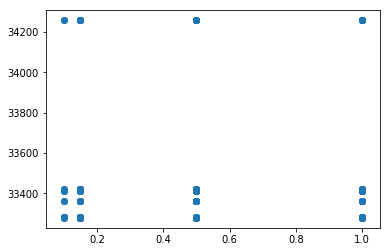

In [206]:
plt.scatter(x=df['raw_Al_concentration'], y=df['raw_hz'])

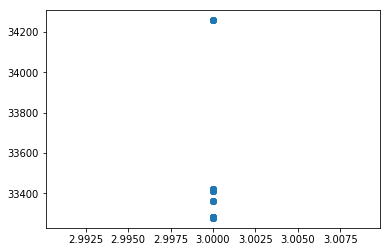

In [207]:
plt.scatter(x=df['raw_Li_concentration'], y=df['raw_hz'])